In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
%cd /mydrive/yolov11

Mounted at /content/gdrive
/content/gdrive/.shortcut-targets-by-id/1N1e6L9Tga2bF3c9mKY8K1qjRhbLw7xHn/yolov11


In [2]:
#%pip install -qr requirements.txt # install dependencies or no need
import torch
import os
from IPython.display import Image, clear_output  # to display images

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")
import ultralytics
ultralytics.checks()

Ultralytics 8.3.128 🚀 Python-3.12.11 torch-2.8.0+cu126 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 39.0/107.7 GB disk)


In [3]:
from ultralytics import YOLO

In [4]:
# Load a model
model = YOLO("yolo11l-pose.pt")

In [ ]:
model(source="/content/gdrive/MyDrive/yolov7-main/pose-tests", conf=0.3, save=True)

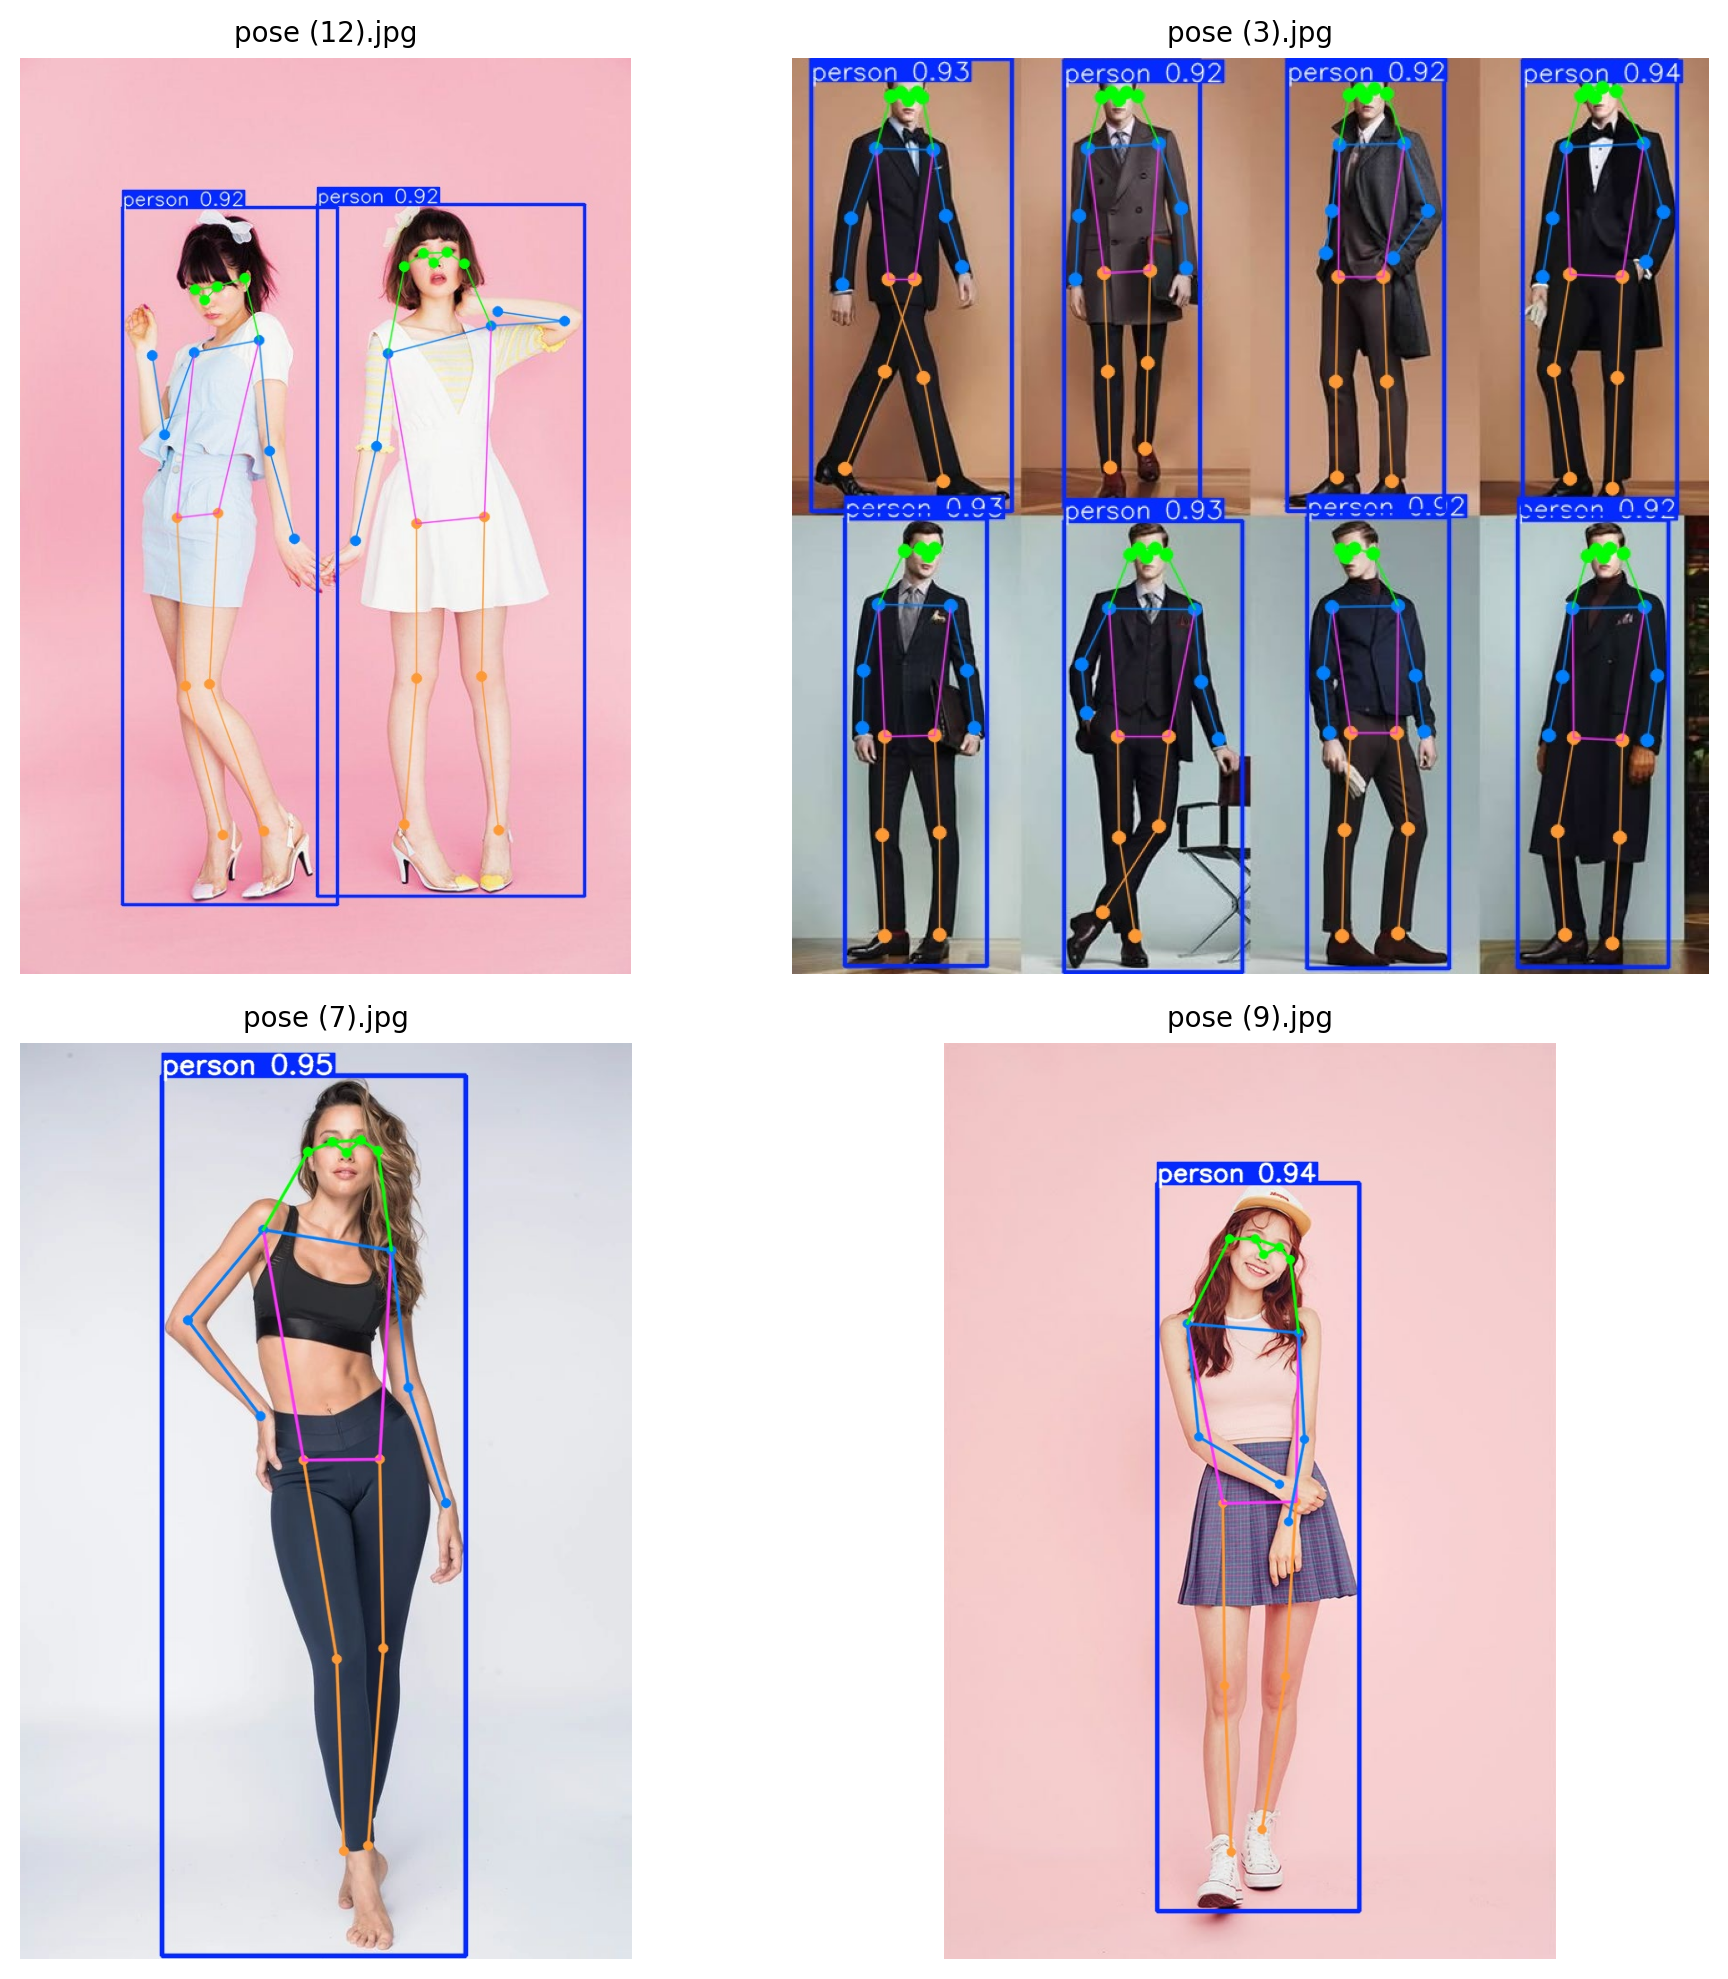

In [15]:
#display inference on ALL test images
# import glob
# from IPython.display import Image, display

# for image_path in glob.glob(f'runs/pose/predict5/*.jpg'):
#       display(Image(filename=image_path, height=500))
#       print("\n")

import glob
import matplotlib.pyplot as plt
import math
import cv2

# Collect all result images
image_paths = glob.glob('runs/pose/predict5/*.jpg')

# Grid config
cols = 2
rows = math.ceil(len(image_paths) / cols)

plt.figure(figsize=(10, 5 * rows), dpi=200)  # higher DPI = sharper

for idx, image_path in enumerate(image_paths):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(rows, cols, idx + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(image_path.split("/")[-1], fontsize=10)

plt.tight_layout()
plt.show()

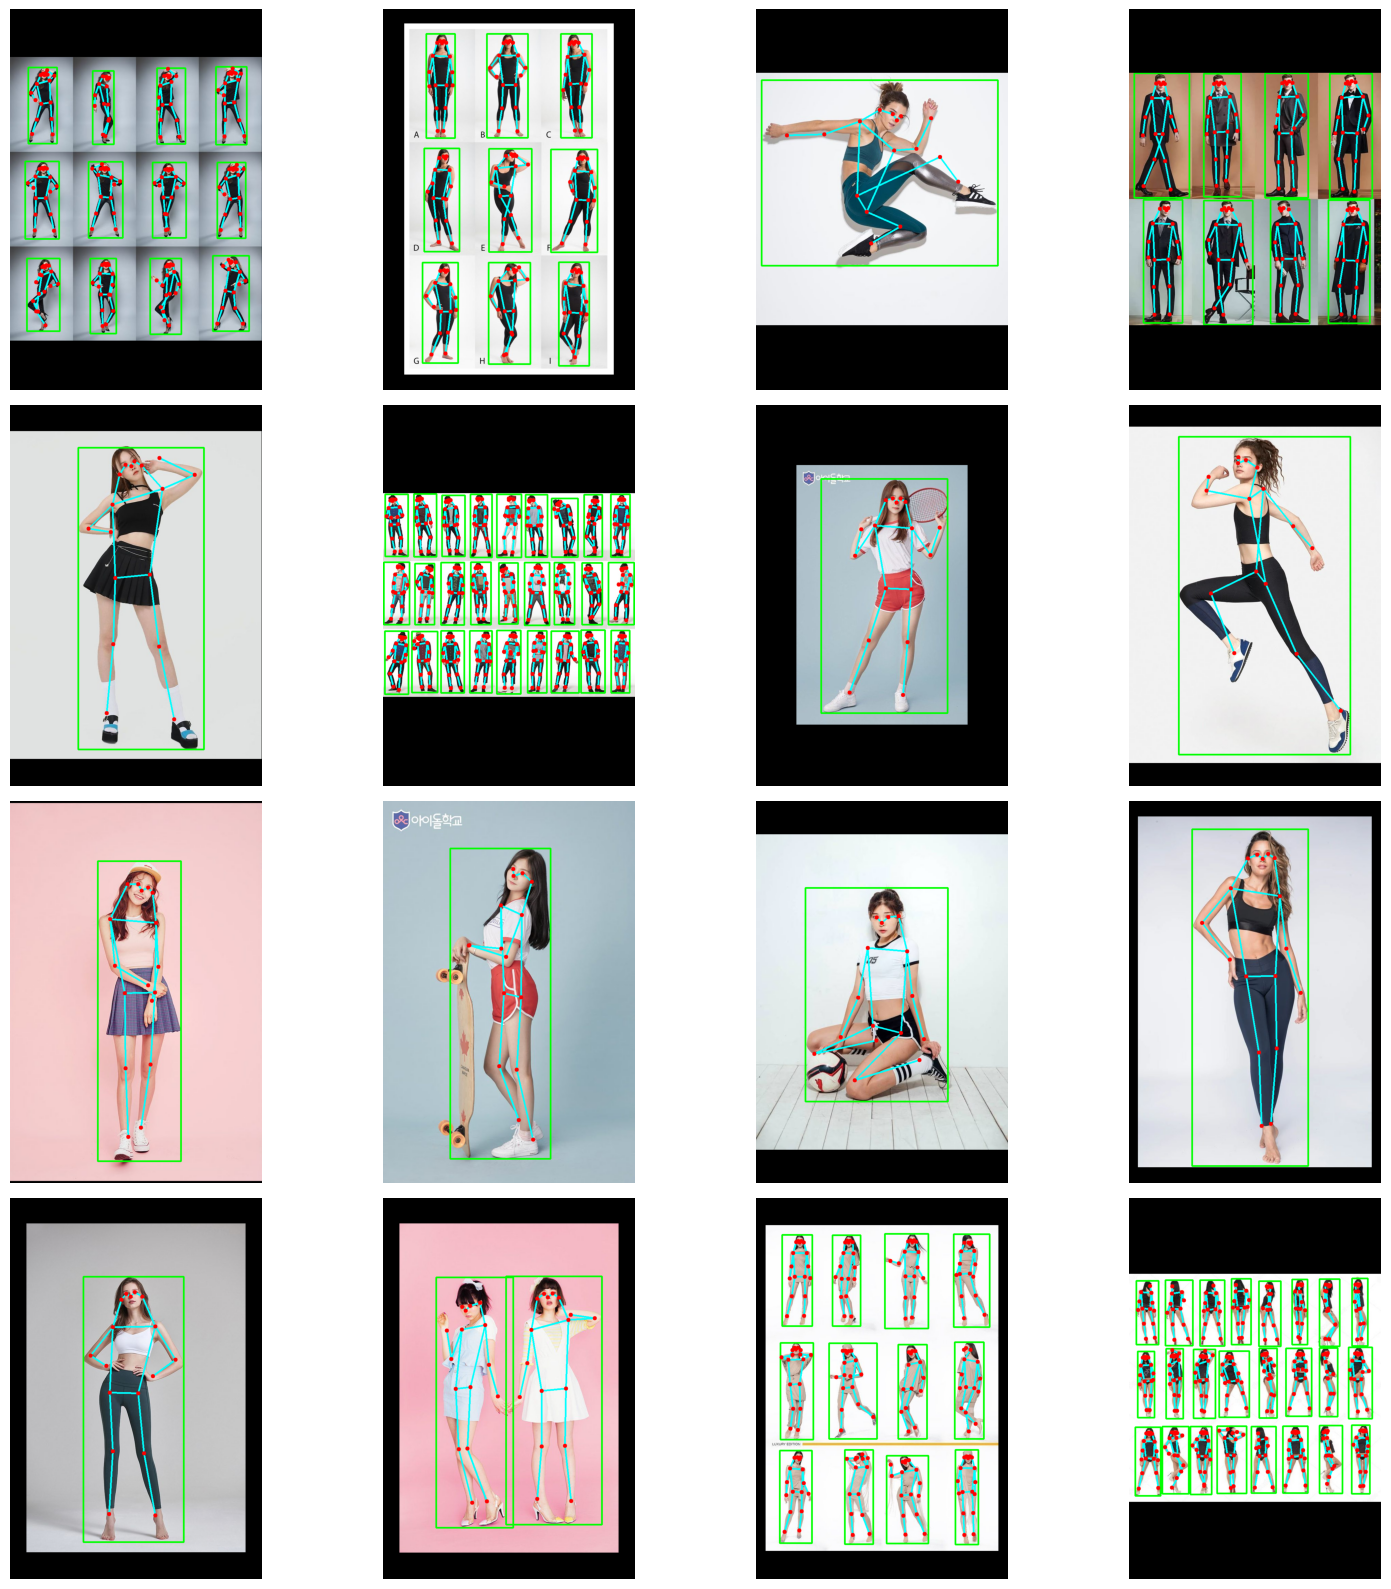

In [9]:
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- Config ---
val_dir = "/content/gdrive/MyDrive/Pytorch-Models/datasets/pose-tests"
model_path = 'yolo11l-pose.pt'
score_thr = 0.3

# Load YOLOv11 Pose model
model = YOLO(model_path)

num_samples = 16
skeleton = [
    [0, 1], [0, 2],       # Nose to eyes
    [1, 3], [2, 4],       # Eyes to ears
    [3, 5], [4, 6],       # ears to shoulders
    [5, 6],               # Shoulders
    [5, 7], [7, 9],       # Left Arm
    [6, 8], [8, 10],      # Right Arm
    [5, 11], [6, 12],     # Torso
    [11, 12],             # Hip
    [11, 13], [13, 15],   # Left Leg
    [12, 14], [14, 16],   # Right Leg
]

# --- Load Images ---
all_imgs = [f for f in os.listdir(val_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
selected_imgs = random.sample(all_imgs, min(num_samples, len(all_imgs)))

img_list = []
img_sizes = []

for img_name in selected_imgs:
    img_path = os.path.join(val_dir, img_name)
    img_cv = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
    img_list.append((img_name, img_path, img_rgb))
    img_sizes.append(img_rgb.shape[:2])

max_height = max(h for h, w in img_sizes)
max_width = max(w for h, w in img_sizes)

# --- Plotting ---
cols = 4
rows = (len(img_list) + cols - 1) // cols
plt.figure(figsize=(4 * cols, 4 * rows))

for idx, (img_name, img_path, img_rgb) in enumerate(img_list):
    img = cv2.imread(img_path)

    # Inference with YOLOv11 Pose
    results = model.predict(source=img, conf=score_thr, verbose=False)

    img_vis = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)

    all_kpts_scaled = []

    for result in results:
        if result.boxes is None or result.keypoints is None:
            continue

        boxes = result.boxes.xyxy.cpu().numpy()
        scores = result.boxes.conf.cpu().numpy()
        kpts = result.keypoints.xy.cpu().numpy()  # shape: (n, 6, 2)
        if result.keypoints.conf is not None:
            kpts_conf = result.keypoints.conf.cpu().numpy()
        else:
            kpts_conf = np.ones((kpts.shape[0], kpts.shape[1]), dtype=np.float32)

        for i in range(len(scores)):
            if scores[i] < score_thr:
                continue

            x1, y1, x2, y2 = boxes[i]
            # Convert coordinates to integers
            cv2.rectangle(img_vis, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 3)

            kpts_scaled = []
            for k in range(len(kpts[i])):
                kx, ky = kpts[i][k]
                kp_score = kpts_conf[i][k]

                if kp_score > 0.3 and not (int(kx) == 0 and int(ky) == 0):
                    kpts_scaled.append((int(kx), int(ky)))
                else:
                    kpts_scaled.append(None)
            all_kpts_scaled.append(kpts_scaled)

    # Draw links first (for all detected objects)
    for kpts_scaled in all_kpts_scaled:
        for (p1, p2) in skeleton:
            if kpts_scaled[p1] is not None and kpts_scaled[p2] is not None:
                cv2.line(img_vis, kpts_scaled[p1], kpts_scaled[p2], (0, 255, 255), 4)

    # Draw keypoint circles last (for all detected objects)
    for kpts_scaled in all_kpts_scaled:
        for pt in kpts_scaled:
            if pt is not None:
                cv2.circle(img_vis, pt, 6, (255, 0, 0), -1)

    # Padding
    h, w = img_vis.shape[:2]
    top = (max_height - h) // 2
    bottom = max_height - h - top
    left = (max_width - w) // 2
    right = max_width - w - left
    img_padded = cv2.copyMakeBorder(img_vis, top, bottom, left, right,
                                    borderType=cv2.BORDER_CONSTANT, value=(0, 0, 0))

    plt.subplot(rows, cols, idx + 1)
    plt.imshow(img_padded)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Load a model
model = YOLO("yolov8l-pose.pt")
model(source="/content/gdrive/MyDrive/yolov7-main/pose-tests", conf=0.3, save=True)

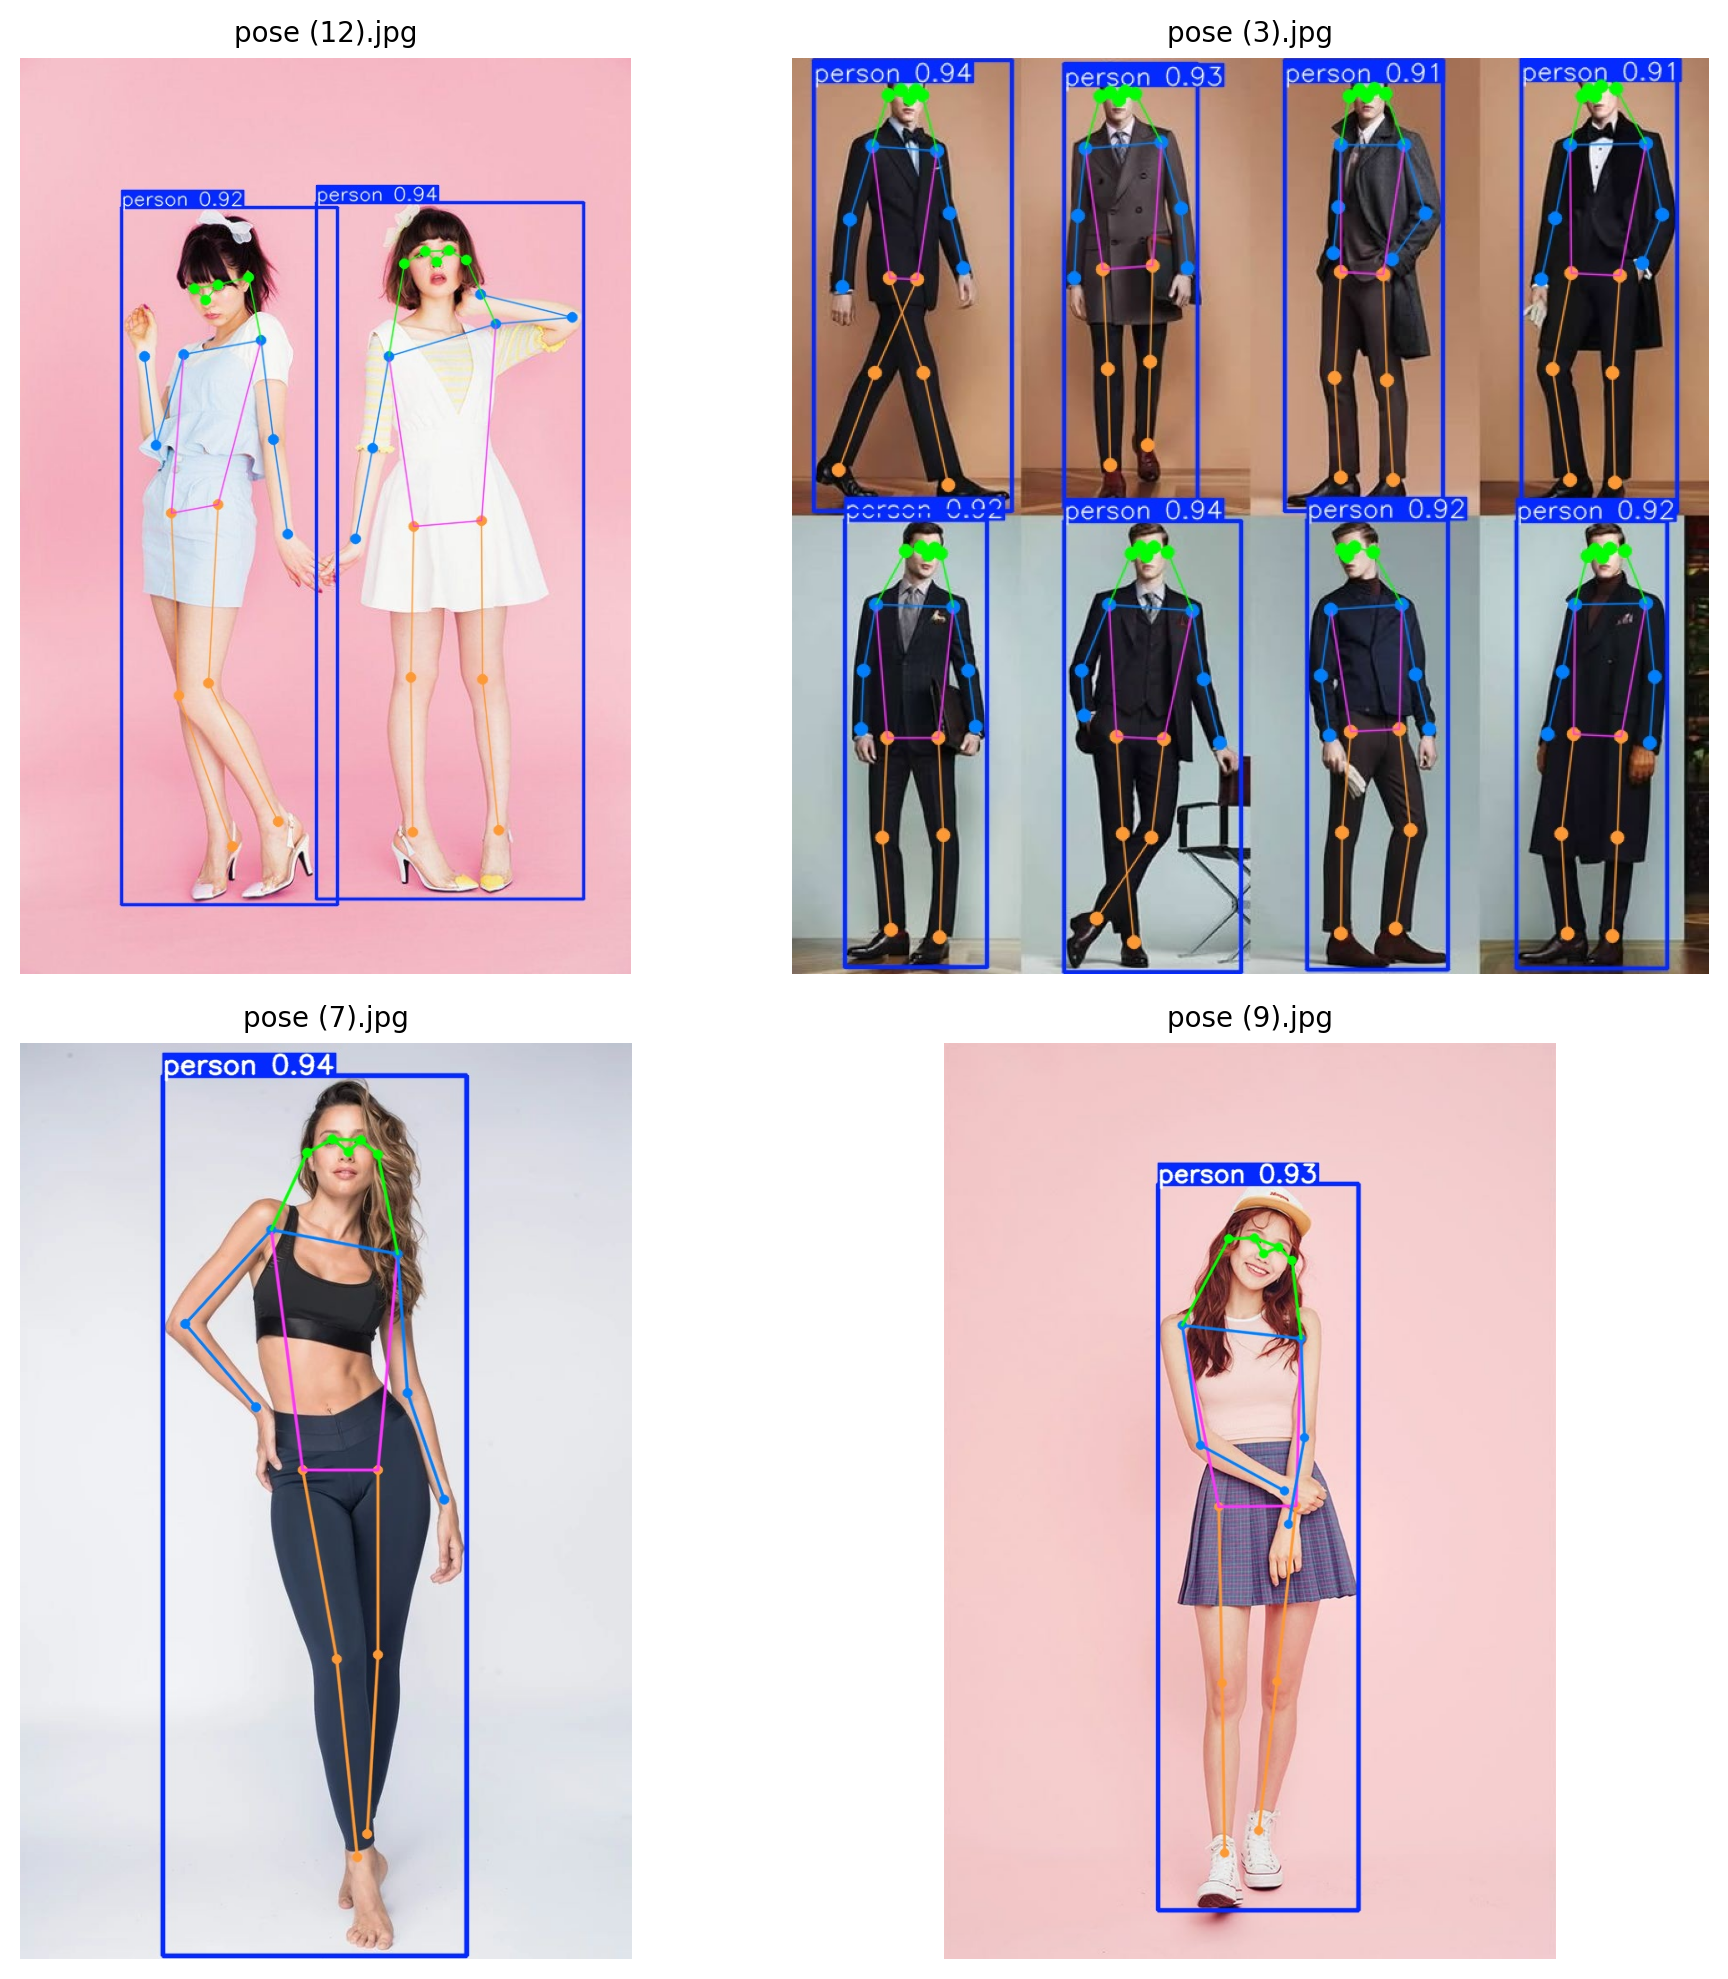

In [13]:
#display inference on ALL test images
import glob
import matplotlib.pyplot as plt
import math
import cv2

# Collect all result images
image_paths = glob.glob('runs/pose/predict6/*.jpg')

# Grid config
cols = 2
rows = math.ceil(len(image_paths) / cols)

plt.figure(figsize=(10, 5 * rows), dpi=200)  # higher DPI = sharper

for idx, image_path in enumerate(image_paths):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(rows, cols, idx + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(image_path.split("/")[-1], fontsize=10)

plt.tight_layout()
plt.show()

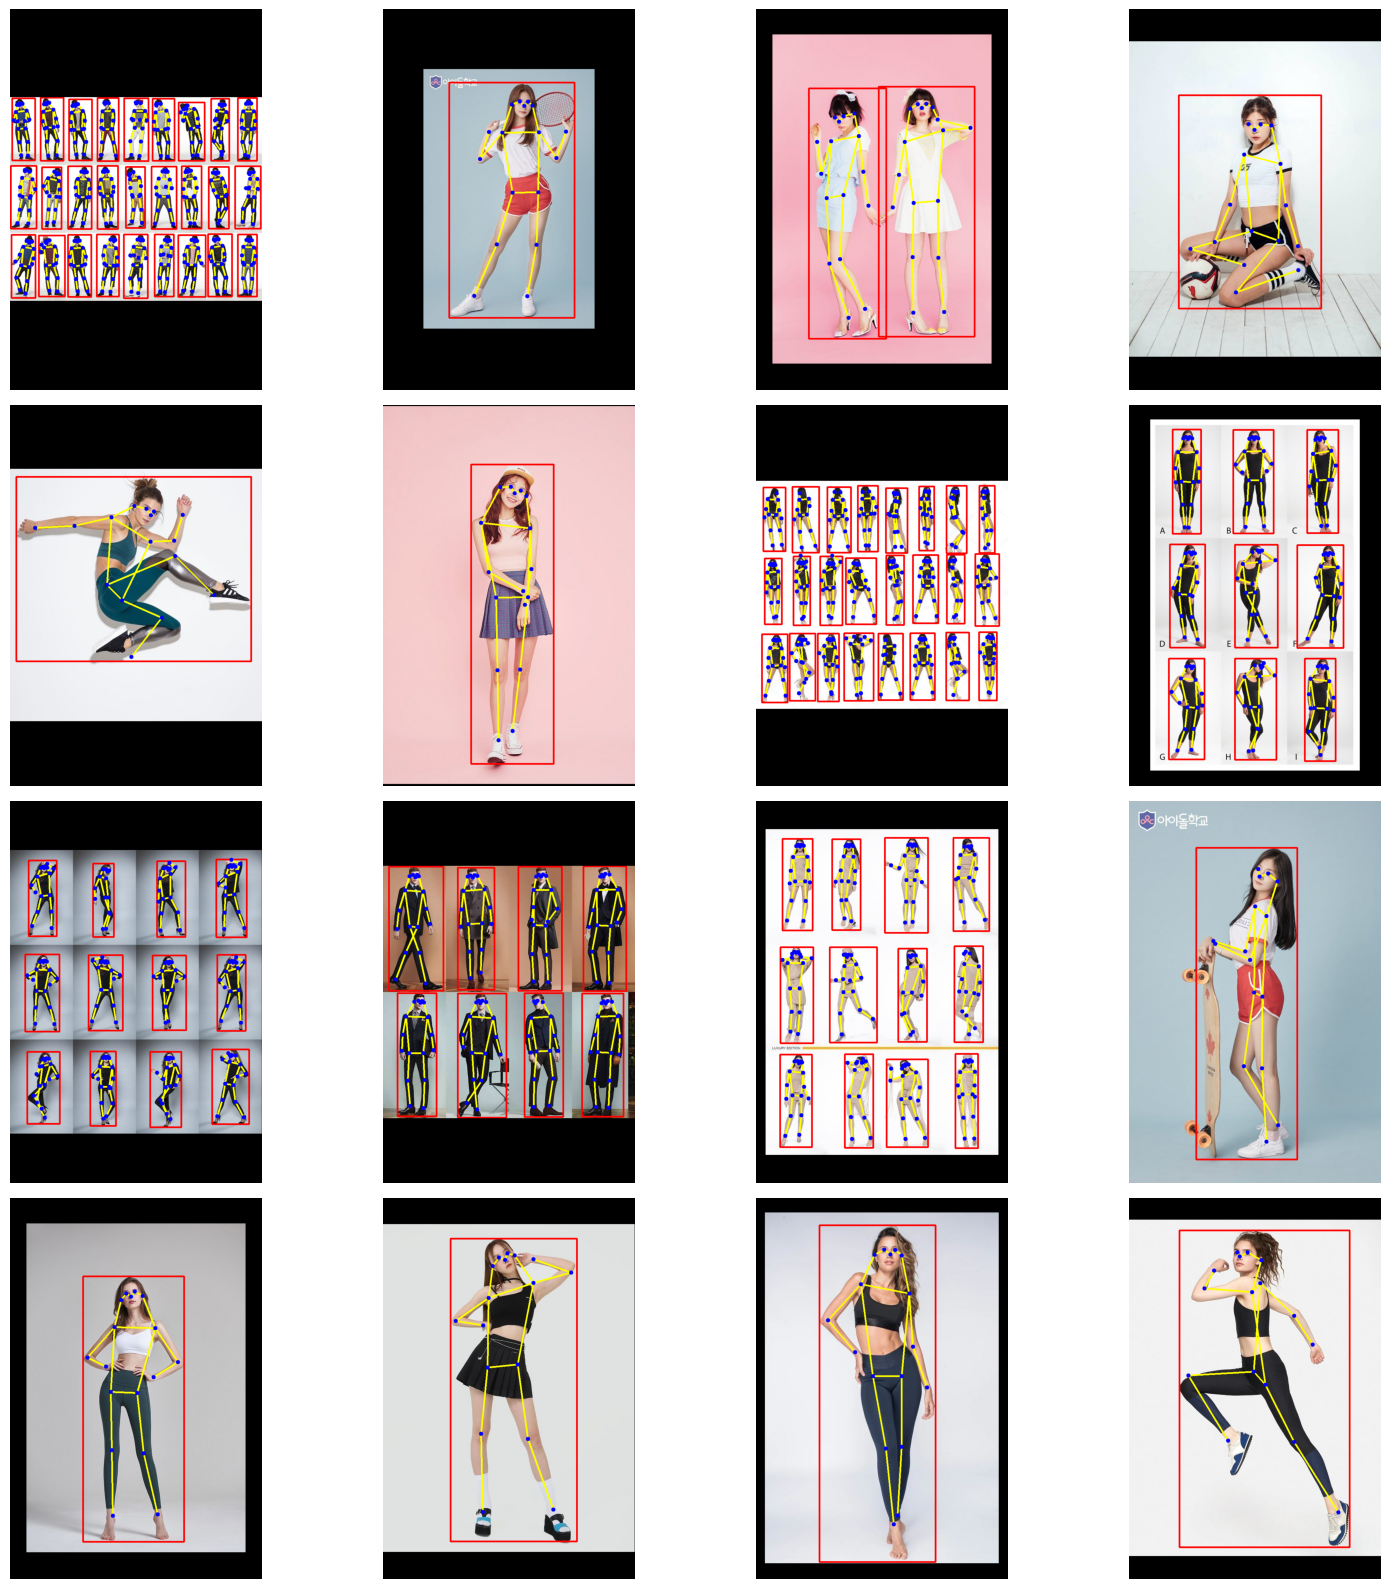

In [14]:
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- Config ---
val_dir = "/content/gdrive/MyDrive/Pytorch-Models/datasets/pose-tests"
model_path = 'yolov8l-pose.pt'
score_thr = 0.3

# Load YOLOv11 Pose model
model = YOLO(model_path)

num_samples = 16
skeleton = [
    [0, 1], [0, 2],       # Nose to eyes
    [1, 3], [2, 4],       # Eyes to ears
    [3, 5], [4, 6],       # ears to shoulders
    [5, 6],               # Shoulders
    [5, 7], [7, 9],       # Left Arm
    [6, 8], [8, 10],      # Right Arm
    [5, 11], [6, 12],     # Torso
    [11, 12],             # Hip
    [11, 13], [13, 15],   # Left Leg
    [12, 14], [14, 16],   # Right Leg
]

# --- Load Images ---
all_imgs = [f for f in os.listdir(val_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
selected_imgs = random.sample(all_imgs, min(num_samples, len(all_imgs)))

img_list = []
img_sizes = []

for img_name in selected_imgs:
    img_path = os.path.join(val_dir, img_name)
    img_cv = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
    img_list.append((img_name, img_path, img_rgb))
    img_sizes.append(img_rgb.shape[:2])

max_height = max(h for h, w in img_sizes)
max_width = max(w for h, w in img_sizes)

# --- Plotting ---
cols = 4
rows = (len(img_list) + cols - 1) // cols
plt.figure(figsize=(4 * cols, 4 * rows))

for idx, (img_name, img_path, img_rgb) in enumerate(img_list):
    img = cv2.imread(img_path)

    # Inference with YOLOv11 Pose
    results = model.predict(source=img, conf=score_thr, verbose=False)

    img_vis = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)

    all_kpts_scaled = []

    for result in results:
        if result.boxes is None or result.keypoints is None:
            continue

        boxes = result.boxes.xyxy.cpu().numpy()
        scores = result.boxes.conf.cpu().numpy()
        kpts = result.keypoints.xy.cpu().numpy()  # shape: (n, 6, 2)
        if result.keypoints.conf is not None:
            kpts_conf = result.keypoints.conf.cpu().numpy()
        else:
            kpts_conf = np.ones((kpts.shape[0], kpts.shape[1]), dtype=np.float32)

        for i in range(len(scores)):
            if scores[i] < score_thr:
                continue

            x1, y1, x2, y2 = boxes[i]
            # Convert coordinates to integers
            cv2.rectangle(img_vis, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 3)

            kpts_scaled = []
            for k in range(len(kpts[i])):
                kx, ky = kpts[i][k]
                kp_score = kpts_conf[i][k]

                if kp_score > 0.3 and not (int(kx) == 0 and int(ky) == 0):
                    kpts_scaled.append((int(kx), int(ky)))
                else:
                    kpts_scaled.append(None)
            all_kpts_scaled.append(kpts_scaled)

    # Draw links first (for all detected objects)
    for kpts_scaled in all_kpts_scaled:
        for (p1, p2) in skeleton:
            if kpts_scaled[p1] is not None and kpts_scaled[p2] is not None:
                cv2.line(img_vis, kpts_scaled[p1], kpts_scaled[p2], (255, 255, 0), 4)

    # Draw keypoint circles last (for all detected objects)
    for kpts_scaled in all_kpts_scaled:
        for pt in kpts_scaled:
            if pt is not None:
                cv2.circle(img_vis, pt, 6, (0, 0, 255), -1)

    # Padding
    h, w = img_vis.shape[:2]
    top = (max_height - h) // 2
    bottom = max_height - h - top
    left = (max_width - w) // 2
    right = max_width - w - left
    img_padded = cv2.copyMakeBorder(img_vis, top, bottom, left, right,
                                    borderType=cv2.BORDER_CONSTANT, value=(0, 0, 0))

    plt.subplot(rows, cols, idx + 1)
    plt.imshow(img_padded)
    plt.axis('off')

plt.tight_layout()
plt.show()